# Training Perceptron with Genetic Algorithm
# Introduction
The problem:
In this assignment, we’ll be using both a Genetic Algorithm and Perceptron to perform binary classification on a breast cancer dataset. We will do the classification by finding a hyperplane which separates the data points of the two different classes, and we will compare the results of these two approaches. 

We have provided code stubs in this notebook to get you started, and give hints about the structure of the code.

You need to compare the performance of 2 algorithms on the dataset:
- Genetic Algorithm with variations as described later
- Perceptron Algorithm which you will code

You will need to submit your finished Jupyter notebook in which you should report the performances in the form of tables or a list as well as plots.

![picture](https://drive.google.com/uc?export=view&id=1wRUX0I803AvXbbkWiD1r4_MKuE3mBQdr)

## Approach:  
Let’s start with a few definitions.
- Individual (aka “chromosome”): a plane in space. It is specified by a weight vector and a bias.
- Population: a collection of possible planes (i.e., collection of individuals)
- Parents: two planes that are combined to create a new plane
- Mating pool: a collection of parents that are used to create our next population (thus creating the next generation of plane)
- Fitness: a function that tells us how good each plane is (in our case, how effectively the plane separates the dataset)
- Mutation: a way to introduce variation in our population by randomly modifying values of the plane's coefficients
- Elitism: a way to carry the best individuals into the next generation    
  
Our GA will proceed in the following steps:
- 1. Create the population
- 2. Rank the population according to fitness in decreasing order
- 3. Select the mating pool
- 4. Breed
- 5. Mutate to create the next generation
- 6. Repeat  

In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
import operator
import math
from sklearn.datasets import load_breast_cancer
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

First we define the range of weight and bias:

In [2]:
maxweight = 100.0 # This constant will be used to generate random weights and biases for planes

Here we load the dataset. It is a `(N, dim)` matrix containing a set of points in 30-dimensional space

In [3]:
breast_cancer = sklearn.datasets.load_breast_cancer()

dataset = breast_cancer.data
print("Shape of our dataset: ", dataset.shape)
dim = dataset.shape[1] # Dimension of each sample in the dataset

targets = breast_cancer.target   # Our labels

Shape of our dataset:  (569, 30)


We separate the data into X_train, X_test, Y_train, and Y_test using `train_test_split`.

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset, targets, test_size = 0.2, stratify = targets, shuffle=True)

## Create necessary classes and functions
We first create a Plane class that will allow us to create and handle our planes. Again, these are represented by the w vector, and the b value. Within the Plane class, there is a `predictset` method, which generates predictions based on this plane and a given set of points.

For each point, if $x_{1}w_{1} + x_{2}w_{2} +...x_{dim}w_{dim} + b = x\cdot w + b > 0 $, we predict the point to have a label of 1. Otherwise, we predict the point to have a label of 0.

We have two fitness methods. One of them scores based on the number of points that are correctly classified with this `Plane`. The other one should take the inverse of the sum of the distance of the misclassified vectors. In both cases, the larger the fitness score the better. 

The `accuracy` method will run predictions and then determine the accuracy of those predictions. 

**TODO** (1.1) (3 points)
1. Complete `fitness_numcorrect` method. (1 point)
2. Complete `perceptron_fitness` method. (1 point) (FREE POINT)
3. Complete `accuracy` method. (1 point)

In [5]:
class Plane:
    def __init__(self, w, b):
        """
        w : Weight vector of size (dim,)
        b : Bias (float)
        """
        self.w = w
        self.b = b
    
    def __repr__(self):
        """
        For printing..
        """
        return ' '.join([str(x) for x in np.append(self.w, self.b)])
        
    def predictset(self, points):
        """
        points: Matrix containing set of points of size (n, dim)
        This function returns predictions for multiple examples
        """
        return np.where((np.dot(points , self.w) + self.b) > 0,1,0)
    
    def fitness_numcorrect(self, data, targets):
        """
        data : n x dim matrix
        targets : n x 1 matrix of 0's and 1's representing the ground truth classification
        output: An integer value. 
        Our first fitness function is defined to be the number of correctly classified points in the training dataset. 
        """
        #YOUR CODE HERE
        return np.sum(self.predictset(data) == targets)

    def perceptron_fitness(self, data, targets):
        """
        This is the 2nd fitness function that used the inverse distance. 
        """
        target01 = []
        for i in targets:
            if i == 0:
                target01.append(-1)
            elif i == 1:
                target01.append(1)
        
        # Can you figure out why this is the distances of all the misclassified points?
        x = np.multiply((data @ self.w + self.b),target01)[self.predictset(data)!=targets]
        
        if len(x) == 0:
            return 0
        else:
            return  -1/(np.sum(x))
        
        

    def fitness(self, data, targets, fitness_type):
        """
        Wrapper function for fitness.
        fitness_type is a string specifying which fitness function to use.
        """
        if fitness_type == "numcorrect":
            return self.fitness_numcorrect(data, targets)
        elif fitness_type == "perceptron_fitness":
            return self.perceptron_fitness(data, targets)

        print("Invalid fitness type")

    def accuracy(self, data, targets):
        """
        data : n x dim matrix
        targets : n x 1 matrix of 0's and 1's representing the ground truth classification
        This function should return the accuracy of the plane on the dataset
        """
        #YOUR CODE HERE
        classify = self.predictset(data)
        return (np.sum(classify == targets) / len(targets))

## Create our initial population
Plane generator.  
We now can make our initial population (aka first generation). To do so, we need a way to create a function that produces random planes. To create an individual, we randomly select the weights of the plane equation. Even though we are starting out with a completely random initial population, there is still a chance for convergence. 

The first function here produces one random individual, and in the next function, we create the whole initial population by repeatedly calling randomPlane().

**TODO** (1.2) (2 points)
1. Complete `randomPlane` function. `np.random.rand()` might be useful here. (1 point) 
2. Complete `initialPopulation` function. (1 point)

In [6]:
def randomPlane():
    """
    Creates a random hyperplane. The components are uniformly selected at random
    from -maxweight to maxweight
    
    input: None
    output: Plane class object 
    """
    #YOUR CODE HERE
    w = np.random.uniform(-maxweight, maxweight, dim)
    b = np.random.uniform(-maxweight, maxweight)
    return Plane(w, b)
    
def initialPopulation(popSize):
    """
    Create inital population of a given size.
    Returns a list of random planes
    """
    #YOUR CODE HERE
    population = []
    
    for i in range(popSize):
        population.append(randomPlane())
    
    return population

Note: we only have to use these functions to create the initial population. Subsequent generations will be produced through breeding and mutation.

## Create the genetic algorithm - Rank by Fitness
Rank individuals  
Next, the evolutionary fun begins. To simulate our “survival of the fittest”, we can make use of Fitness to rank each individual in the population. Our output will be an ordered list with the plane IDs and each associated fitness score.

In [7]:
def rankPopulation(population, fitness_type="numcorrect"):
    """
    This function sorts the given population in decreasing order of the fitness score.
    Returns a list of ordered pairs of (index, fitness) where index is the index of the
    individual within the population
    """
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = population[i].fitness(X_train, Y_train,fitness_type)
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

## Select the mating pool
There are a few options for how to select the parents that will be used to create the next generation. The most common approaches are either fitness proportionate selection (aka “roulette wheel selection”) or tournament selection:
- Fitness proportionate selection: The fitness of each individual relative to the population is used to assign a probability of selection. Think of this as the fitness-weighted probability of being selected.
- Tournament selection: A set number of individuals are randomly selected from the population and the one with the highest fitness in the group is chosen as the first parent. This is repeated to chose the second parent.  

Another design feature to consider is the use of **elitism**. With elitism, the best performing individuals from the population will automatically carry over to the next generation, ensuring that the most successful individuals persist.  

In our case, we’ll create the mating pool using both the elitism and fitness proportionate selection. Suppose the population is N and there is a predefined parameter `eliteSize`, the process is as follows:

- Rank the individuals in the population using `rankPopulation` method.

- Select **ALL** top-`eliteSize`-fitness individuals into the mating pool.

- From the **remaining** population, select $N-\mathrm{eliteSize}$ individuals, where the probability of each individual be sampled is propotional to its fitness.


Hint:
1. Return the list of **indices** of individuals selected into the mating pool.

2. The size of the resulting mating pool should also be **N** (same as the original population).

3. For weighted selection, you may find `np.random.choice` handy.

 Ultimately, the selection function returns a list of plane IDs, which we can use to create the mating pool in the matingPool function.

**TODO** (1.3) (2 points)
1. Complete `selection` function. (2 points)

The code below is setup for fitness proportionate selection. You can remove the code if you want to implement tournament selection if you feel like tournament selectioin is easier.

In [8]:
def selection(popRanked, eliteSize):
    """
    Input:
    popRanked: output of rankPopulation()
    eliteSize: number of highest ranked individuals we will retain in the next generation.
    
    Output: selectionResults
    This function returns a list of **indices** of individuals selected to form the mating pool.
    """
    selectionResults = []
    
    # step 1: Retaining the individuals of the top-eliteSize-best fitness in the population.
    # BEGIN YOUR CODE
    for ind, val in popRanked[:eliteSize]:
        selectionResults.append(ind)
    # END YOUR CODE
    
    
    # step 2: sample from the rest using the fitness-propotionate selection
    # step 2.1: convert fitness to weight
    indices, fitness = zip(*popRanked[eliteSize:])
    weights = np.array(fitness) / np.sum(fitness)
    # step 2.2: weighted sampling
    # BEGIN YOUR CODE
    for val in range(len(popRanked)-eliteSize):
        selectionResults.append(np.random.choice(indices, p=weights))
    # END YOUR CODE
    
    return selectionResults


Now that we have the IDs of the planes that will make up our mating pool from the selection function, we can create the mating pool. We’re simply extracting the selected individuals from our population.

In [9]:
def matingPool(population, selectionResults):
    """
    Create the mating pool.
    Returns a list Planes that has been selected. 
    """
    matingpool = [population[i] for i in selectionResults]
    return matingpool

## Breed
With our mating pool created, we can create the next generation in a process called crossover (aka “breeding”). Each plane can be represented by a combined list, containing the $w$ vector followed by the $b$ constant. 

In `crossover_ordered`, We employ a random selection process to choose a subset from the first parent string, and subsequently we populate the remaining portion with genes from the second parent in their original sequential order. See the image below for an example.

![picture](parent_child.png)

**[Hint]**: 

- In other words, for a gene at position i in the child's string, it could be either the gene at position i in parent 1's string or the gene at position i in parent 2's string. But all genes inherited from parent 1 should be one consecutive portion in both parent 1's and child's strings.

- The ordered-crossover breeding algorithm you need to implement here is slightly different from the one you will implement for the traveling salesman problem (in assignment 2).

There is a crossover wrapper function, which is what gets called later. Inside this function, based on the passed crossover type, we call the appopriate function to be used in the genetic algorithm.

In addition to ordered crossover, you need to implement two additional crossover functions which you must devise. Feel free to design your own algorithms.

**TODO** (1.4) (7 points)
1. Complete `crossover_ordered` function. (3 points)
2. Complete `your_own_crossover` function. (2 points)
3. Complete `your_own_crossover2` function. (2 points)

Optinoal : Name your crossover functions

In [10]:
def crossover_ordered(plane1, plane2):
    """
    plane1, plane2 : type Plane
    Ordered crossover as described in the write-up
    return: a new plane that is a child of plane1 and plane2. 
    """
    #YOUR CODE HERE
    # step 1: select and copy the subset from parent 1
    start = random.randint(0, len(plane1.w) - 1)
    end = random.randint(start + 1, len(plane1.w))
    
    child_w = np.copy(plane1.w)
    child_b = np.random.choice([plane1.b, plane2.b])
    # step 2: fill the remaining positions with genes from parent 2
    for i in range(start, end):
        child_w[i] = plane2.w[i]
    
    child = Plane(child_w, child_b)
    return child

def your_own_crossover(plane1, plane2):
    """
    Uniform crossover; equal probability of being chosen from either parent
    """
    #YOUR CODE HERE
    child_w = np.copy(plane1.w)
    child_b = np.random.choice([plane1.b, plane2.b])
    
    for i in range(len(plane1.w)):
        if random.random() < 0.5:
            child_w[i] = plane1.w[i]
        else:
            child_w[i] = plane2.w[i]
    
    child = Plane(child_w, child_b)
    return child 

def your_own_crossover2(plane1, plane2):
    """
    One-point crossover; everything to the right of the selected point is crossed over
    """
    #YOUR CODE HERE
    point = random.randint(0, len(plane1.w) - 1)
    
    child_w = np.copy(plane1.w)
    child_b = np.random.choice([plane1.b, plane2.b])
    
    for i in range(point, len(plane1.w)):
        child_w[i] = plane2.w[i]
        
    child = Plane(child_w, child_b)
    return child  

def crossover(plane1, plane2, crossover_type):
    """
    Wrapper function for crossover. Returns the child formed by crossing over 
    plane1 and plane2. 
    crossover_type is a string specifying which crossover function to use.
    """
    if crossover_type == "ordered":
        return crossover_ordered(plane1, plane2)
    # INSERT YOUR OWN CROSSOVER FUNCTION NAMES HERE
    elif crossover_type == "your_own_crossover":
        return your_own_crossover(plane1, plane2)
    elif crossover_type == "your_own_crossover2":
        return your_own_crossover2(plane1, plane2)
    print("Crossover type invalid")
    return None 

Next, we’ll generalize this to create our offspring population. We will use elitism to retain the elites from the current population. Then, we use the crossover wrapper function to fill out the rest of the next generation. 

Hints: 
- The top-eliteSize individuals should 'ALL' be retained.
- The size of next generation should be the same as the size of parent generation. 

**TODO** (1.5) (3 points)
1. Complete `breedPopulation`. (3 points)

In [11]:
def breedPopulation(matingpool, eliteSize, crossover_type):
    """
    matingpool: list of individuals selected to form the mating pool
    eliteSize: number of highest ranked individuals preserved in the next generation
    crossover_type: string specifying which crossover function to use
    This function returns the new population created by pairing individuals from the matingpool 
    and calling the crossover function to return a child for each pair. 
    In order to fill out the rest of the next generation,
    we need population_size - elite_size random pairs of Planes. 
    """
    # YOUR CODE HERE
    elites = matingpool[:eliteSize]
    
    children = []
    len_children = len(matingpool) - eliteSize
    
    for i in range(len_children):
        parent1, parent2 = random.sample(matingpool[eliteSize:], 2)
        children.append(crossover(parent1, parent2, crossover_type))
    
    return elites + children

## Mutate
Mutation serves an important function in GA, as it helps to avoid local convergence by introducing novel weights/bias that will allow us to explore other parts of the solution space. In this assignment, we shall assume that we mutate a certain fraction of the population, as specified in the variable `mutationRate`.

Note that there can be several possible ways to mutate an individual for this problem. You are free to design how to mutate an individual. One possible way could be: change one or some of the weights to a random value within the range $\mathrm{[-maxweight, maxweight]}$. 

To generate a random index, you can use `np.random.randint`. To generate random noise, you can use `np.random.rand`

**TODO** (1.6) (4 points)
1. Implement `mutate` function. (2 points) 
2. Implement `mutatePopulation` function. (2 points)

In [12]:
def mutate(individual, mutationRate):
    """
    individual: type Plane
    This function should mutate a single individual and return the mutated individual.
    Hints given in paragraph above
    """
    # YOUR CODE HERE
    mutate_w = np.copy(individual.w)
    mutate_b = np.copy(individual.b)
    
    for i in range(len(mutate_w)):
        if random.random() < mutationRate:
            mut_index = np.random.randint(0, len(mutate_w))
            noise = np.random.uniform(-maxweight, maxweight)
            mutate_w[mut_index] += noise
            mutate_b = individual.b + noise
    
    return Plane(mutate_w, mutate_b)

Next, we can extend the mutate function to run through the new population.  Create a function to run mutation over entire population and return the new population.

Note that **the elites should not be mutated but retained**, **only** apply mutation to those that are not elites

In [13]:
def mutatePopulation(population, mutationRate,eliteSize):
    """
    This function should use the above mutate function to mutate each member of the population. Simply iterate over the 
    population and mutate each individual using the mutationRate. It should then return the mutated population
    """
    mutatedPop = []
    # step 1: retain all elites
    # BEGIN YOUR CODE
    elites = population[:eliteSize]
    mutatedPop.extend(elites)
    # END YOUR CODE
    
    # step 2: mutate those that are not the elites
    # BEGIN YOUR CODE
    for individual in population[eliteSize:]:
        mut_ind = mutate(individual, mutationRate)
        mutatedPop.append(mut_ind)
    # END YOUR CODE

    return mutatedPop

## Repeat
We’re almost there. Let’s pull these pieces together to create a function that produces a new generation. First, we rank the planes in the current generation using `rankPopulation`. We then determine our potential parents by running the `selection` function, which allows us to create the mating pool using the `matingPool` function. Finally, we then create our new generation using the `breedPopulation` function (passing in crossover_type) and then applying mutation using the `mutatePopulation` function.

**TODO** (1.7) (3 points)
1. Implement`nextGeneration`. (3 points)

In [14]:
def nextGeneration(currentGen, eliteSize, mutationRate, crossover_type, fitness_type):
    """
    This function takes in the current generation, eliteSize ,and mutationRate and returns the next generation.
    The size of the next_generation has to equal to the size of currentGen. 
    """
    #YOUR CODE HERE
    # Rank
    pop_ranked = rankPopulation(currentGen, fitness_type)
    
    # Potential parents + matingpool
    parents = selection(pop_ranked, eliteSize)
    matingpool = matingPool(currentGen, parents)
    
    # New generation
    newGen = breedPopulation(matingpool, eliteSize, crossover_type)
    
    # Mutating
    next_generation = mutatePopulation(newGen, mutationRate, eliteSize)
    
    return next_generation

###### Final step: Evolution in motion
We finally have all the pieces in place to create our GA! All we need to do is create the initial population, and then we can loop through as many generations as we desire. 

Of course we want to see how much we’ve improved, so we capture the initial and final training/testing fitness and accuracy.

The progress of evolution is also worth checking. We should record the fitness of the best individual at every generation. 



The input parameters:
1. `popSize`: The population size at each generation. 
2. `eliteSize`: The size of the elite population. 
3. `mutationRate`: The probabilty of an individual gets mutated. 
4. `generations`: The maxmium number of generations to run for. 
5. `crossover_type`: A string which specifies which crossover function to use.
6. `fitness_type` : A string which specifies which fitness_type method to use.

The outputs:
1. `bestPlane`: The Plane with the highest fitness score(`bestRoute_list[-1]`). 
3. `fitness_record`: A list of the best fitness from each generation.(For the purpose of plotting.) `fitness_record[0]` is the best fitness score from the first generation. 



We recommand the following settings. Feel free to apply settings beyond the recommended values. It is possible to have a flat fitness curve. The initial population can contain Planes that have a relatively high fitness:

1. `popSize` : 15-50 
2. `eliteSize`: 0.1 * `popsize`
3. `mutationRate`: > 0.1
4. `generation`: > 1000 



Advice for debugging:

First, I recommand checking the size of your population in every generation. Your algorthm will not run correctly if the population size changes between generations. Second, plot the `fitness_record` and see if it is increasing monotonically, or the elite population has not been retained properly.



**TODO** (1.8) (5 points)
1. Implement`geneticAlgorithm`. (3 points)
2. Run the `geneticAlgorithm` (2 point)

In [15]:
def geneticAlgorithm(popSize, eliteSize, mutationRate, generations, crossover_type, fitness_type):
    """
    This function should run the genetic algorithm for the specified number of generations
    by following the process outlined  in the "Approach" section given earlier in this notebook. 
    It should print the initial and final training and testing accuracy as well as 
    initial and final fitness.
    It should also generate plots showing the training as well as testing fitness
    with respect to generations.
    """
    # Initialize the population
    population = initialPopulation(popSize)
    
    # Track the best plane and its fitness score
    best_plane = None
    best_fitness = -float('inf')
    
    # Track the fitness scores during the evolution
    fitness_record = []
    
    for gen in range(generations):
        population = nextGeneration(population, eliteSize, mutationRate, crossover_type, fitness_type)
        
        fitness_scores = rankPopulation(population, fitness_type)
        
        # Find the best plane in this generation
        best_plane_index, best_fitness_in_gen = fitness_scores[0]

        # If the best plane in this generation has higher fitness, update the best_plane
        if best_fitness_in_gen > best_fitness:
            best_plane = population[best_plane_index]
            best_fitness = best_fitness_in_gen
        
        # Append the best fitness score in this generation to the fitness record
        fitness_record.append(best_fitness_in_gen)
        
        # Print the progress every 100 generations
        if gen % 100 == 0:
            print(f"Generation {gen}, Best Fitness: {best_fitness_in_gen}")

    # Accuracy/Correct Predictions
    print("Final Population Size:", len(population))
    print("Training Accuracy:", best_plane.accuracy(X_train, Y_train))
    print("Testing Accuracy:", best_plane.accuracy(X_test, Y_test))
    print("Number of Correctly Predicted Samples on Training Data:", int(len(Y_train) * best_plane.accuracy(X_train, Y_train)))
    print("Number of Correctly Predicted Samples on Testing Data:", int(len(Y_test) * best_plane.accuracy(X_test, Y_test)))

    # Plot
    plt.plot(range(1, len(fitness_record) + 1), fitness_record)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Fitness vs. Generation")
    plt.show()
    
    return best_plane, fitness_record

Now run your algorithm with a population size of 55, an elite size of 5, a mutation rate of 0.12, 500 generations, and the 'ordered' crossover algorithm. Run one experiment with fitness type `perceptron_fitness` and the rest of the hyperparameters should be the same. Report the number of correctly predicted samples for each experiment. 

Generation 0, Best Fitness: 2.6680067041882047e-06
Generation 100, Best Fitness: 3.880595857514968e-05
Generation 200, Best Fitness: 3.880595857514968e-05
Generation 300, Best Fitness: 3.880595857514968e-05
Generation 400, Best Fitness: 4.0752473214142946e-05
Final Population Size: 55
Training Accuracy: 0.9296703296703297
Testing Accuracy: 0.9210526315789473
Number of Correctly Predicted Samples on Training Data: 423
Number of Correctly Predicted Samples on Testing Data: 105


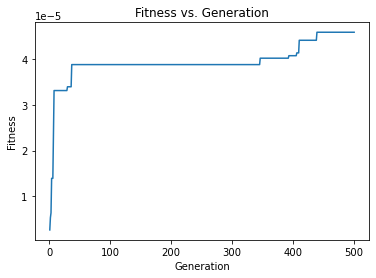

(-40.731593498145656 -76.34340300657587 187.9513326200835 11.25215874247435 -25.720294065979502 -601.887224497295 -111.77582847262082 -472.2615542864482 -22.5654530407213 37.73912900657568 311.6531054300061 152.24858260582556 -137.3131180501793 -50.74536638591205 436.5563848489393 284.2374384148238 -299.39240118357105 153.2551044872445 48.66427122281945 -531.3431949736265 530.3789402102661 -47.56945570522438 -115.8211925984009 -20.22826909315077 57.30061395580485 519.0909868737627 -192.667256593926 -523.8563816685368 198.829809621296 89.21292714692994 444.212138859775,
 [2.6680067041882047e-06,
  5.338107138073278e-06,
  6.4034222051813035e-06,
  1.3945820076933666e-05,
  1.3945820076933666e-05,
  1.3945820076933666e-05,
  2.31525702938836e-05,
  3.313248394382024e-05,
  3.313248394382024e-05,
  3.313248394382024e-05,
  3.313248394382024e-05,
  3.313248394382024e-05,
  3.313248394382024e-05,
  3.313248394382024e-05,
  3.313248394382024e-05,
  3.313248394382024e-05,
  3.313248394382024e

In [16]:
# YOUR CODE HERE
geneticAlgorithm(55,5,0.12,500,'ordered','perceptron_fitness')

Generation 0, Best Fitness: 6.043939406578618e-06
Generation 100, Best Fitness: 3.160149594110555e-05
Generation 200, Best Fitness: 3.3744040943341823e-05
Generation 300, Best Fitness: 3.3744040943341823e-05
Generation 400, Best Fitness: 3.3744040943341823e-05
Final Population Size: 55
Training Accuracy: 0.9362637362637363
Testing Accuracy: 0.8947368421052632
Number of Correctly Predicted Samples on Training Data: 426
Number of Correctly Predicted Samples on Testing Data: 102


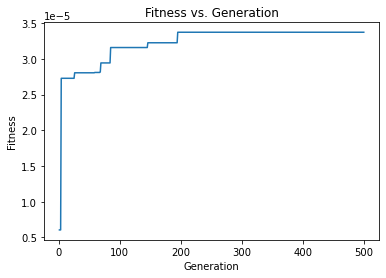

(270.4383581750998 31.062721961893317 11.84754148813144 17.582900501165383 418.3337019392647 102.66868312573537 201.52695658016822 126.34352125344918 -11.238208659491448 -7.203815965519006 224.92032846249154 546.808795295877 -49.20265876069404 -77.82076325240241 6.845138127039476 -39.84010267056313 -409.8609232668367 -171.48361006621855 306.6774335214767 70.29255298912452 391.91948341324314 -57.84620223510831 39.741258432891144 -29.86503657122101 -365.9022290903634 14.978504954250177 -245.471186269086 47.01556675841513 -646.9995138115626 18.557776558617405 462.2766538196813,
 [6.043939406578618e-06,
  6.043939406578618e-06,
  6.043939406578618e-06,
  2.7291258890122468e-05,
  2.7291258890122468e-05,
  2.7291258890122468e-05,
  2.7291258890122468e-05,
  2.7291258890122468e-05,
  2.7291258890122468e-05,
  2.7291258890122468e-05,
  2.7291258890122468e-05,
  2.7291258890122468e-05,
  2.7291258890122468e-05,
  2.7291258890122468e-05,
  2.7291258890122468e-05,
  2.7291258890122468e-05,
  2.7

In [17]:
# YOUR CODE HERE
geneticAlgorithm(55,5,0.12,500,'ordered','perceptron_fitness')

Now repeat the prcoess above, but this time with one of the cross-over algorithm you devised.

Generation 0, Best Fitness: 6.9687695144769315e-06
Generation 100, Best Fitness: 2.3292595835996644e-05
Generation 200, Best Fitness: 2.3292595835996644e-05
Generation 300, Best Fitness: 2.3292595835996644e-05
Generation 400, Best Fitness: 2.3292595835996644e-05
Final Population Size: 55
Training Accuracy: 0.8945054945054945
Testing Accuracy: 0.8245614035087719
Number of Correctly Predicted Samples on Training Data: 407
Number of Correctly Predicted Samples on Testing Data: 94


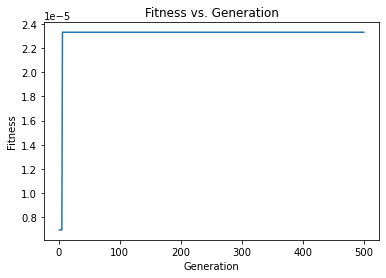

(-50.2303364495946 -84.45677255761454 9.885584688789024 -1.730084020214946 84.503652015275 -60.13074008907993 80.61439320688163 0.9219589655634621 -19.74301388783519 -11.750873521515516 -90.28157171956757 -64.0234288543933 89.68646091417057 -55.278947305855006 81.90108989243896 -86.88540049062198 66.16816199813863 99.07394723009105 53.319051578805755 20.016190339248396 35.40230934666299 80.68243044794073 97.14347763411294 -10.931133262720877 -32.87884477280025 4.842007230921681 66.19191957918963 -123.32601424774181 -61.7179763789828 -91.4464241427081 -24.189472776410383,
 [6.9687695144769315e-06,
  6.9687695144769315e-06,
  6.9687695144769315e-06,
  6.9687695144769315e-06,
  6.9687695144769315e-06,
  2.3292595835996644e-05,
  2.3292595835996644e-05,
  2.3292595835996644e-05,
  2.3292595835996644e-05,
  2.3292595835996644e-05,
  2.3292595835996644e-05,
  2.3292595835996644e-05,
  2.3292595835996644e-05,
  2.3292595835996644e-05,
  2.3292595835996644e-05,
  2.3292595835996644e-05,
  2.32

In [18]:
# YOUR CODE HERE
geneticAlgorithm(55,5,0.12,500,'your_own_crossover','perceptron_fitness')

Generation 0, Best Fitness: 1.2042868354174926e-05
Generation 100, Best Fitness: 1.2104763133828843e-05
Generation 200, Best Fitness: 1.3604436287424474e-05
Generation 300, Best Fitness: 1.3604436287424474e-05
Generation 400, Best Fitness: 1.536031793978788e-05
Final Population Size: 55
Training Accuracy: 0.9120879120879121
Testing Accuracy: 0.8333333333333334
Number of Correctly Predicted Samples on Training Data: 415
Number of Correctly Predicted Samples on Testing Data: 95


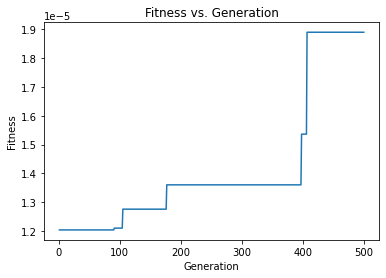

(140.38247421474256 -46.16126024243766 -63.051136849852696 3.142625800748668 -468.1903986940567 -191.20719595658682 469.3353589585774 -75.44409730676821 -367.3873787705404 -192.1226438888802 -179.13653601351245 925.3874715050669 -310.1248374360595 -50.112044129088915 107.23237373098492 -132.55678570419963 -17.139128598686256 -658.3406738698739 111.56706856557113 -953.9198447372227 841.3157477248744 14.271913825531584 31.670336318076714 -14.16447120737719 239.93101709736177 558.4879431340233 266.3606290002877 329.3581710792196 448.20117824988574 -594.3307958486214 -1017.3666302455891,
 [1.2042868354174926e-05,
  1.2042868354174926e-05,
  1.2042868354174926e-05,
  1.2042868354174926e-05,
  1.2042868354174926e-05,
  1.2042868354174926e-05,
  1.2042868354174926e-05,
  1.2042868354174926e-05,
  1.2042868354174926e-05,
  1.2042868354174926e-05,
  1.2042868354174926e-05,
  1.2042868354174926e-05,
  1.2042868354174926e-05,
  1.2042868354174926e-05,
  1.2042868354174926e-05,
  1.204286835417492

In [19]:
# YOUR CODE HERE
geneticAlgorithm(55,5,0.12,500,'your_own_crossover','perceptron_fitness')


# Part 2: Perceptron with Gradient Descent

In this section we will code up the perceptron algorithm with gradient descent.

In the following cell, we create the main Perceptron class and its necessary functions. The psuedocode for perceptron `fit` method is below:
```
def fit

Input: X, Y, epochs, learning_rate

Output: None

for each epoch:
    for each xi and yi in X and Y:
        y_predicted = predict(x)
        if y_predicted = 1 and yi = 0:
            w := w - learning_rate * xi
            b := b - learning_rate
        if y_predicted = 0 and yi = 1:
            w := w + learning_rate * xi
            b := b + learning_rate            

```

**TODO** 2.1 (5 points)
1. Complete `model` method. (1 point) (Hint: Same as how our GA individual predicts.)
2. Complete `fit` method. (3 point) (Hint: Feel free to change the number of epochs and learning rate from the default values.)
3. Train the perceptron and print the training/test accuracy. (1 point)

In [20]:
class Perceptron:
    def __init__(self):
        self.w = None
        self.b = None

    def model(self, x):
        """
        This function returns the prediction for a single example x
        """
        return np.where((np.dot(self.w, x) + self.b) > 0, 1, 0) #YOUR CODE HERE

    def predict(self, X):
        """ 
        returns the predictions for multiple examples X
        Size of X: (n, dim)
        """
        Y = []
        for x in X:
            res = self.model(x)
            Y.append(res)
        return np.array(Y)

    def fit(self, X, Y, epochs=500, learning_rate=0.01):
        """
        This function should train the perceptron by running gradient descent 
        through the entire datase. The 
        perceptron algorithm can be found in the lecture slides. Psuedocode has been provided above
        """
        #initializing the weights to 1 and bias to 0
        self.w = np.ones(X.shape[1])# YOUR CODE HERE
        self.b =  0# YOUR CODE HERE
        
        for i in range(epochs):
            for x, y in zip(X, Y):
                y_pred = self.model(x)
                # YOUR CODE HERE
                if y_pred == 1 and y == 0:
                    self.w -= learning_rate * x
                    self.b -= learning_rate
                elif y_pred == 0 and y == 1:
                    self.w += learning_rate * x
                    self.b += learning_rate

In [21]:
perceptron = Perceptron()


# YOUR CODE BELOW
epochs = 500
learning_rate = 0.01

perceptron.fit(X_train,Y_train, epochs, learning_rate)
Y_pred_test = perceptron.predict(X_test)
Y_pred_train = perceptron.predict(X_train)
# Return the perceptron test accuracy. 
print("Perceptron training accuracy:", accuracy_score(Y_pred_train, Y_train))
print("Perceptron test accuracy:", accuracy_score(Y_pred_test, Y_test))

Perceptron training accuracy: 0.9318681318681319
Perceptron test accuracy: 0.9122807017543859


# Part 3: Report and Submission Guidelines (15 points)

The purpose of this assignment is to compare the performance of the Genetic Algorithm in varying conditions and Perceptron for this problem. 

You need to implement a total of **3** crossover functions and **2** fitness functions, as well as **1** mutation function. You can choose any mutation rate or even a different mutation strategy which gives you the best testing performance.

The best way to compare different algorithms is to run many iterations, and record the results. For this assignment, each time you call the `geneticAlgorithm` function, you use a certain crossover and fitness function. There are 3 crossover functions and 2 fitness function, which means there are 6 possible combinations. We want to compare the performance of these different combinations with each other as well as with Perceptron Gradient Descent.

For each combination (ie. crossover_ordered paired with fitness1, crossover_ordered paired with fitness2) you should run the `geneticAlgorithm` function 5 times at least. Then, take the average final **testing** accuracy for this specific combination. List the average testing accuracies below.(Create additional cells as needed).  Also include the average accuracy of your Perceptron with gradient descent algorithm.

The final report should contain an accuracy table (or as a list), that has the average final testing accuracies for each combination of the genetic algorithm. Additionally, for one of the combinations, please produce one plot (pick one of the 5 or more iterations) that plots fitness (the best fitness in that generation) versus number of generations.

**TODO** 3. You need to present the following in your report (15 points):
- Accuracies table/list as specified above (5 points)
- Fitness vs generation curve (5 points)
- Description of your mutation function as well as crossover functions (5 points)

##### Please submit your report as a pdf file to gradescope.
##### Feel free to add more blocks below to run your experiments

#### Ordered/Numcorrect

Generation 0, Best Fitness: 361
Generation 100, Best Fitness: 413
Generation 200, Best Fitness: 413
Generation 300, Best Fitness: 413
Generation 400, Best Fitness: 413
Final Population Size: 55
Training Accuracy: 0.9076923076923077
Testing Accuracy: 0.868421052631579
Number of Correctly Predicted Samples on Training Data: 413
Number of Correctly Predicted Samples on Testing Data: 99


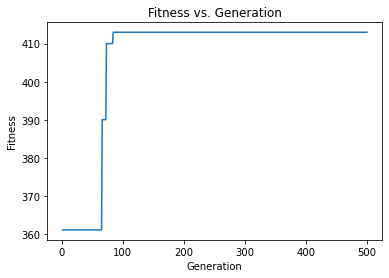

(-74.75077649255877 22.287934315493956 223.11641423979268 82.20719031031004 150.34236764814239 -375.8579805448485 172.68468948358213 -63.084851380213365 -60.067849111393144 -47.56468497480597 76.88020928230137 -75.88655667260072 8.56158478392507 29.98205066865529 388.73704641234025 -175.25375125999312 362.4328856381594 -11.20981425183868 38.09040217460695 -82.86415445004552 28.189287925366273 47.83149590967271 -52.67351566752559 -83.07444019637857 323.7909370746702 -96.75497286809147 -269.58483639055555 29.688047575996023 166.44992154137816 172.57762145445957 66.8925324742101,
 [361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  361,
  3

In [22]:
geneticAlgorithm(55,5,0.12,500,'ordered','numcorrect')

Generation 0, Best Fitness: 390
Generation 100, Best Fitness: 409
Generation 200, Best Fitness: 409
Generation 300, Best Fitness: 409
Generation 400, Best Fitness: 409
Final Population Size: 55
Training Accuracy: 0.8989010989010989
Testing Accuracy: 0.8771929824561403
Number of Correctly Predicted Samples on Training Data: 409
Number of Correctly Predicted Samples on Testing Data: 100


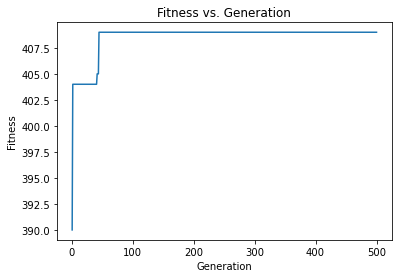

(-1.1035515041496424 -41.76129308800455 354.56327465722245 76.21480367984283 -289.4266757920255 190.1632239838345 175.05314760154914 17.762925018650897 169.16314865918758 229.65212266526618 160.648185015771 274.01526590909737 -90.96375233462096 167.57669057375907 -284.02991738208397 46.61440381594244 309.99322619394786 -126.16995848747548 323.7578643282604 143.79540434177562 149.4112861888815 -42.79156035533401 -101.181464539985 -92.12026383872224 -81.13382908946215 -258.6531662559638 199.69753066462096 131.93717431840426 -46.329107203348464 133.82626194342873 463.8936191761306,
 [390,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  405,
  405,
  405,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
 

In [23]:
geneticAlgorithm(55,5,0.12,500,'ordered','numcorrect')

Generation 0, Best Fitness: 379
Generation 100, Best Fitness: 416
Generation 200, Best Fitness: 416
Generation 300, Best Fitness: 416
Generation 400, Best Fitness: 425
Final Population Size: 55
Training Accuracy: 0.9340659340659341
Testing Accuracy: 0.8859649122807017
Number of Correctly Predicted Samples on Training Data: 425
Number of Correctly Predicted Samples on Testing Data: 101


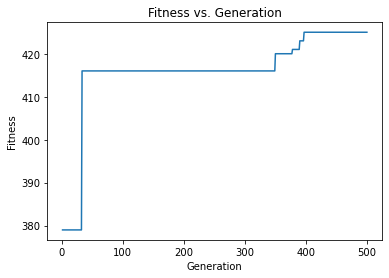

(-41.90792633955955 -513.3756547826251 244.78756705031213 184.59048730376117 -70.47229728570049 -144.98054998794 203.70698951788478 39.12209768182427 -758.2927145841394 476.83242573822247 -141.10408690402312 -296.95357937559254 -336.06984553450474 27.710619525636986 -105.00202511218191 48.91615272795093 772.2695908883893 -565.8461216112025 305.8912040899922 -533.4106039979483 -290.3117886342634 -65.51067940595851 726.2797336998296 -238.5326041465672 -601.3978494379924 -385.76973106202115 633.0724733337453 419.337669427857 -881.995018668065 -63.59511384767134 473.5191887787588,
 [379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  416,
  416,
  416,
  416,
  416,
  416,
  416,
  416,
  416,
  416,
  416,
  416,
  416,
  416,
  416,
  416,
  416,
  416,
  416,
  416,
  416,
  416,
  416,
  416,
  416,
  416,
  416,
  4

In [24]:
geneticAlgorithm(55,5,0.12,500,'ordered','numcorrect')

Generation 0, Best Fitness: 403
Generation 100, Best Fitness: 419
Generation 200, Best Fitness: 419
Generation 300, Best Fitness: 419
Generation 400, Best Fitness: 419
Final Population Size: 55
Training Accuracy: 0.9208791208791208
Testing Accuracy: 0.8859649122807017
Number of Correctly Predicted Samples on Training Data: 419
Number of Correctly Predicted Samples on Testing Data: 101


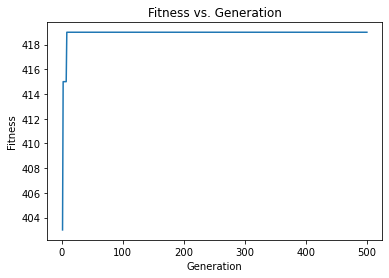

(14.490374379751088 -19.810237230768394 160.08488751842307 73.28923142390826 49.02160954985858 -85.44255520626145 2.2955582776708354 -28.02343983735281 103.49123737660682 -84.4296647832907 -11.0140737957813 -90.0636155528205 48.995666762540054 5.3195320629759095 -36.050202309509885 -17.255528237688566 18.630047338952167 -64.5431614627061 -64.36530577438151 9.97336559408059 13.159152710591712 50.67492585559182 125.88055134227463 -91.61728629570155 88.70677482047765 -76.0856416846822 -65.73111177486416 92.52491677545163 -21.865123170626077 36.56817834208434 86.1544756867971,
 [403,
  415,
  415,
  415,
  415,
  415,
  415,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,
  419,


In [25]:
geneticAlgorithm(55,5,0.12,500,'ordered','numcorrect')

Generation 0, Best Fitness: 396
Generation 100, Best Fitness: 412
Generation 200, Best Fitness: 412
Generation 300, Best Fitness: 412
Generation 400, Best Fitness: 412
Final Population Size: 55
Training Accuracy: 0.9054945054945055
Testing Accuracy: 0.8859649122807017
Number of Correctly Predicted Samples on Training Data: 412
Number of Correctly Predicted Samples on Testing Data: 101


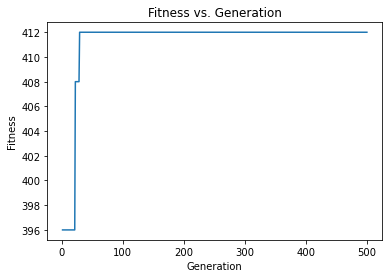

(40.95652735162291 -169.05109239788982 67.69403850132012 22.763574079232427 -192.18779443393112 -162.26329581180744 -226.30637711524278 48.66183985466733 -8.889374100695207 -203.49149450886432 -90.69960480382164 -33.4504663716296 -6.596143691813239 47.05616636395783 94.0446309659735 10.525232819449343 -181.8764891255725 388.07058790952954 78.19508235903088 176.26751891715998 -8.090517146104702 25.939868726405436 46.96045787525668 -30.281830249148797 264.8495852159711 301.7268064689782 -73.20873862294252 -134.5925511288643 -199.30207475955774 35.535803738661144 124.58247743793082,
 [396,
  396,
  396,
  396,
  396,
  396,
  396,
  396,
  396,
  396,
  396,
  396,
  396,
  396,
  396,
  396,
  396,
  396,
  396,
  396,
  396,
  408,
  408,
  408,
  408,
  408,
  408,
  408,
  412,
  412,
  412,
  412,
  412,
  412,
  412,
  412,
  412,
  412,
  412,
  412,
  412,
  412,
  412,
  412,
  412,
  412,
  412,
  412,
  412,
  412,
  412,
  412,
  412,
  412,
  412,
  412,
  412,
  412,
  412,


In [26]:
geneticAlgorithm(55,5,0.12,500,'ordered','numcorrect')

#### Ordered/Perceptron_fitness

Generation 0, Best Fitness: 2.3184152976543266e-06
Generation 100, Best Fitness: 1.8173836380207598e-05
Generation 200, Best Fitness: 1.8738026333600938e-05
Generation 300, Best Fitness: 1.8738026333600938e-05
Generation 400, Best Fitness: 2.1277025849103775e-05
Final Population Size: 55
Training Accuracy: 0.9362637362637363
Testing Accuracy: 0.9122807017543859
Number of Correctly Predicted Samples on Training Data: 426
Number of Correctly Predicted Samples on Testing Data: 104


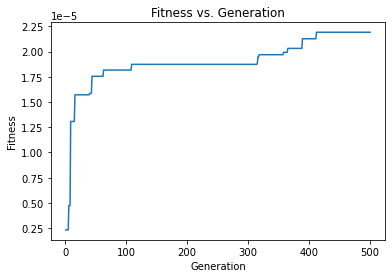

(-6.456940100661718 -15.450617266121412 -35.590251957521566 43.651301794136685 284.7701625248342 -128.28262808416108 -173.73550371422735 -161.97360049847248 -185.0744812921874 293.01643110836596 -192.07597628504064 47.68117130685353 -278.36159241687875 -45.82832059705481 -122.59275638972773 -228.12598637847404 -88.35367481689485 -587.2443171107641 -54.826606038802225 419.564446053007 931.3000297613961 -124.60334650963526 160.83108062673278 -64.29677555890328 -89.81077591582378 66.34399036402763 -363.6217021246492 -518.6273402185209 726.4991732242146 -414.91045277677637 1160.1146514170207,
 [2.3184152976543266e-06,
  2.3184152976543266e-06,
  2.3184152976543266e-06,
  2.3184152976543266e-06,
  2.3184152976543266e-06,
  4.7358089395941444e-06,
  4.7358089395941444e-06,
  4.736759085791895e-06,
  1.3076487464799191e-05,
  1.3076487464799191e-05,
  1.3076487464799191e-05,
  1.3076487464799191e-05,
  1.3076487464799191e-05,
  1.3076487464799191e-05,
  1.3076487464799191e-05,
  1.57192042769

In [27]:
geneticAlgorithm(55,5,0.12,500,'ordered','perceptron_fitness')

Generation 0, Best Fitness: 1.0753108979691489e-05
Generation 100, Best Fitness: 1.999666648196796e-05
Generation 200, Best Fitness: 2.132489136662478e-05
Generation 300, Best Fitness: 2.6987647057773076e-05
Generation 400, Best Fitness: 3.396795447061649e-05
Final Population Size: 55
Training Accuracy: 0.945054945054945
Testing Accuracy: 0.8947368421052632
Number of Correctly Predicted Samples on Training Data: 430
Number of Correctly Predicted Samples on Testing Data: 102


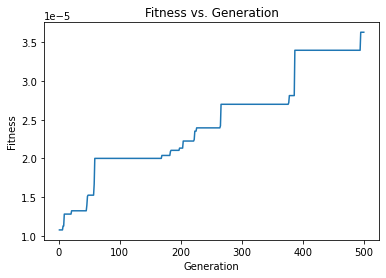

(320.9601053870249 257.69571171241586 5.128898082628687 20.71197688161402 -462.387886942597 -550.3552747395689 -264.5985023550624 474.45169580972464 291.0425953081039 244.30845615527025 52.52760342174095 2.788479233552067 28.289523469182832 -91.0375745854845 -192.3292548057329 -27.723255226679356 -197.09722793808888 233.22618300398042 341.7081966291763 618.8714464164398 546.4714302503053 -273.43012975125544 14.760276475613963 -30.047589290814216 -648.4790833336416 -69.78137667912591 -45.36510720937723 2.440561305428446 142.1299058452011 287.35407879118264 898.1555273556177,
 [1.0753108979691489e-05,
  1.0753108979691489e-05,
  1.0753108979691489e-05,
  1.0753108979691489e-05,
  1.0753108979691489e-05,
  1.0753108979691489e-05,
  1.1261553207334545e-05,
  1.1261553207334545e-05,
  1.2797846168748237e-05,
  1.2797846168748237e-05,
  1.2797846168748237e-05,
  1.2797846168748237e-05,
  1.2797846168748237e-05,
  1.2797846168748237e-05,
  1.2797846168748237e-05,
  1.2797846168748237e-05,
  1

In [28]:
geneticAlgorithm(55,5,0.12,500,'ordered','perceptron_fitness')

Generation 0, Best Fitness: 4.412237841981066e-06
Generation 100, Best Fitness: 2.484947354052595e-05
Generation 200, Best Fitness: 2.484947354052595e-05
Generation 300, Best Fitness: 2.484947354052595e-05
Generation 400, Best Fitness: 2.484947354052595e-05
Final Population Size: 55
Training Accuracy: 0.9164835164835164
Testing Accuracy: 0.8596491228070176
Number of Correctly Predicted Samples on Training Data: 417
Number of Correctly Predicted Samples on Testing Data: 98


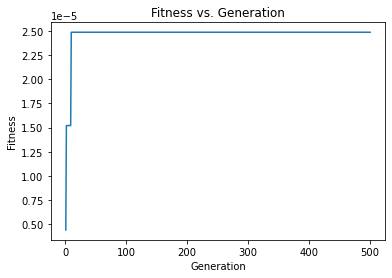

(101.59017321286909 -51.94829323674165 -37.02000139194934 1.53010166023644 -1.096014798813954 37.57855843396477 -99.56059353717053 82.04982808350672 48.31382946185127 131.8028169656801 -40.60797216259856 -80.98351072472217 85.01828480833842 -39.92763068175089 34.8012192688541 -42.094782491921386 90.84783844817419 78.36814442977523 -16.03301875631972 -266.9385173906931 -24.07442688613179 20.464689432648797 144.12969432787253 -14.980766866246626 -146.70038475260904 67.5312154926618 -19.43594216147008 69.54158008807804 108.31676841725354 22.43334482215333 245.66306018094423,
 [4.412237841981066e-06,
  1.5200036251916754e-05,
  1.5200036251916754e-05,
  1.5200036251916754e-05,
  1.5200036251916754e-05,
  1.5200036251916754e-05,
  1.5200036251916754e-05,
  1.5200036251916754e-05,
  1.5200036251916754e-05,
  2.484947354052595e-05,
  2.484947354052595e-05,
  2.484947354052595e-05,
  2.484947354052595e-05,
  2.484947354052595e-05,
  2.484947354052595e-05,
  2.484947354052595e-05,
  2.484947354

In [29]:
geneticAlgorithm(55,5,0.12,500,'ordered','perceptron_fitness')

Generation 0, Best Fitness: 1.0623066137277343e-05
Generation 100, Best Fitness: 1.5707869565982e-05
Generation 200, Best Fitness: 1.5707869565982e-05
Generation 300, Best Fitness: 1.5707869565982e-05
Generation 400, Best Fitness: 1.5707869565982e-05
Final Population Size: 55
Training Accuracy: 0.9186813186813186
Testing Accuracy: 0.9210526315789473
Number of Correctly Predicted Samples on Training Data: 418
Number of Correctly Predicted Samples on Testing Data: 105


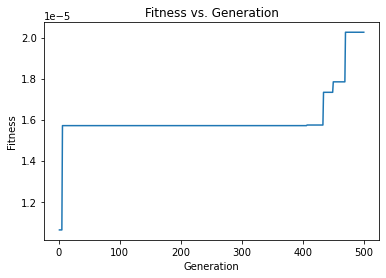

(-358.10286338434537 -204.44901023796868 193.9171145015467 16.016853528820356 283.6123752205292 -84.14247305640178 -666.2543117329006 -580.7602133410483 695.7531231093997 304.27298593247065 -49.49850556001887 -107.96545031748403 -117.19772578127301 -20.35872267117803 -298.08015326624195 238.49124349528907 -127.47354720521776 340.7801280665588 -189.1640664589943 -63.11842269617849 -140.0547693365724 -37.545990352174485 179.049466186373 -44.977562856216565 -335.09759355645764 -282.2256064807768 195.2250207239931 -337.9262741249183 -355.9450064606509 329.12914089567533 2689.9338441180053,
 [1.0623066137277343e-05,
  1.0623066137277343e-05,
  1.0623066137277343e-05,
  1.0623066137277343e-05,
  1.0623066137277343e-05,
  1.5707869565982e-05,
  1.5707869565982e-05,
  1.5707869565982e-05,
  1.5707869565982e-05,
  1.5707869565982e-05,
  1.5707869565982e-05,
  1.5707869565982e-05,
  1.5707869565982e-05,
  1.5707869565982e-05,
  1.5707869565982e-05,
  1.5707869565982e-05,
  1.5707869565982e-05,
 

In [30]:
geneticAlgorithm(55,5,0.12,500,'ordered','perceptron_fitness')

Generation 0, Best Fitness: 1.0971467884251798e-05
Generation 100, Best Fitness: 1.0971467884251798e-05
Generation 200, Best Fitness: 1.0971467884251798e-05
Generation 300, Best Fitness: 1.0971467884251798e-05
Generation 400, Best Fitness: 1.3044172288011188e-05
Final Population Size: 55
Training Accuracy: 0.9252747252747253
Testing Accuracy: 0.9035087719298246
Number of Correctly Predicted Samples on Training Data: 421
Number of Correctly Predicted Samples on Testing Data: 103


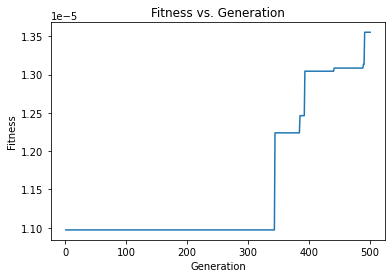

(529.637550255178 -15.047189381481793 -66.29797534870877 68.10804328332893 -347.73517757277193 112.1260276917324 624.3864976282896 -258.7239426058927 303.9217334039773 -286.0151824228659 144.62833833944592 69.11381692036709 -505.54609179775196 -99.6183729907066 739.3936322358315 134.84692296068442 -80.81151179777626 -152.8113643123042 203.78763781633123 471.91794780851137 720.7950383787266 -237.81279975298426 274.60757986214423 -95.34652660311357 -682.8473773953792 -466.9941353879187 216.54309737246143 -434.42239082389847 -836.7731459716101 -68.58911116259937 2340.370201074543,
 [1.0971467884251798e-05,
  1.0971467884251798e-05,
  1.0971467884251798e-05,
  1.0971467884251798e-05,
  1.0971467884251798e-05,
  1.0971467884251798e-05,
  1.0971467884251798e-05,
  1.0971467884251798e-05,
  1.0971467884251798e-05,
  1.0971467884251798e-05,
  1.0971467884251798e-05,
  1.0971467884251798e-05,
  1.0971467884251798e-05,
  1.0971467884251798e-05,
  1.0971467884251798e-05,
  1.0971467884251798e-05,

In [31]:
geneticAlgorithm(55,5,0.12,500,'ordered','perceptron_fitness')

#### Own/Numcorrect

Generation 0, Best Fitness: 368
Generation 100, Best Fitness: 401
Generation 200, Best Fitness: 401
Generation 300, Best Fitness: 401
Generation 400, Best Fitness: 401
Final Population Size: 55
Training Accuracy: 0.8813186813186813
Testing Accuracy: 0.868421052631579
Number of Correctly Predicted Samples on Training Data: 401
Number of Correctly Predicted Samples on Testing Data: 99


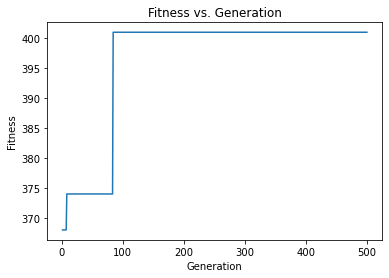

(8.577736745625614 -206.13875053104255 -219.5703623759821 175.47222422072943 -247.51763985914977 318.5634936078816 102.20284765203928 -75.52070594814614 63.77185403775648 137.9034166580588 86.50320543015471 39.64223876104464 162.8882049091298 -11.948455639351295 -365.6700346273137 -71.38594548976259 -243.5929022277337 431.66046831074453 -103.98254874401084 35.27042948900876 181.1272595276464 -288.3894215724036 557.7616462540107 -176.30848261837144 168.0356945610058 36.892022574826235 -157.85579972749986 -155.39329827836218 -212.82522023751514 6.963128902239333 322.6342840911314,
 [368,
  368,
  368,
  368,
  368,
  368,
  368,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
  374,
 

In [32]:
geneticAlgorithm(55,5,0.12,500,'your_own_crossover','numcorrect')

Generation 0, Best Fitness: 402
Generation 100, Best Fitness: 402
Generation 200, Best Fitness: 402
Generation 300, Best Fitness: 402
Generation 400, Best Fitness: 402
Final Population Size: 55
Training Accuracy: 0.9230769230769231
Testing Accuracy: 0.8859649122807017
Number of Correctly Predicted Samples on Training Data: 420
Number of Correctly Predicted Samples on Testing Data: 101


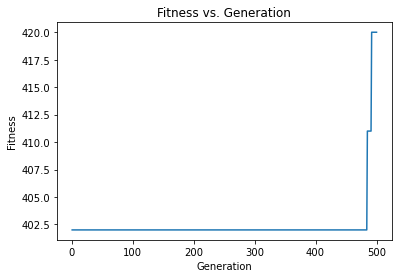

(-202.5198653866016 -863.7307781044475 168.35309308336662 118.72469656075437 336.6875650952645 -221.45667155288925 -330.9835362645419 -543.3546229731082 147.1058566178068 310.45558459452906 431.2199855525476 278.94346715889435 -637.9339899287595 -13.269819805138233 569.8470918244932 18.715019078914793 180.99436712316407 -449.12764167236423 941.2142347798249 735.399776167767 148.84666110861957 214.24228588276173 407.7227366549308 -147.36914375027084 -83.02559620380742 189.56454827456668 -271.47185697471946 227.2703027506006 260.16506094133155 342.43165168135573 850.0620765744762,
 [402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
  402,
 

In [33]:
geneticAlgorithm(55,5,0.12,500,'your_own_crossover','numcorrect')

Generation 0, Best Fitness: 398
Generation 100, Best Fitness: 409
Generation 200, Best Fitness: 410
Generation 300, Best Fitness: 425
Generation 400, Best Fitness: 425
Final Population Size: 55
Training Accuracy: 0.9384615384615385
Testing Accuracy: 0.8771929824561403
Number of Correctly Predicted Samples on Training Data: 427
Number of Correctly Predicted Samples on Testing Data: 100


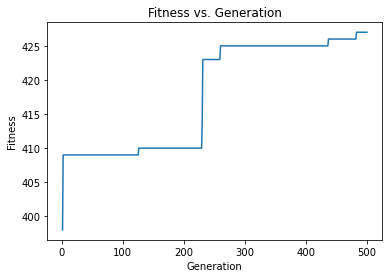

(75.46823572902333 87.45308388153506 341.69582221818996 144.05275109500053 -17.978423599022832 -227.6046853224066 -83.62218774507049 -521.2855274908256 654.7765239862698 -481.15805995952803 37.04833639893613 631.0171609026604 277.95766141119225 -445.3219525008612 -114.25196712482072 659.2964653360489 -448.92531068145297 871.2090329475932 -542.6572036178827 64.51238573345877 372.6575993828389 18.13839357992724 277.4519855594105 -185.08146797771946 -421.95004962987093 -463.51661875689183 246.4038064329989 183.8325216017436 -396.5846055996425 4.020125352722232 2366.9138006300263,
 [398,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  409,
  4

In [34]:
geneticAlgorithm(55,5,0.12,500,'your_own_crossover','numcorrect')

Generation 0, Best Fitness: 379
Generation 100, Best Fitness: 423
Generation 200, Best Fitness: 423
Generation 300, Best Fitness: 423
Generation 400, Best Fitness: 423
Final Population Size: 55
Training Accuracy: 0.9296703296703297
Testing Accuracy: 0.8508771929824561
Number of Correctly Predicted Samples on Training Data: 423
Number of Correctly Predicted Samples on Testing Data: 97


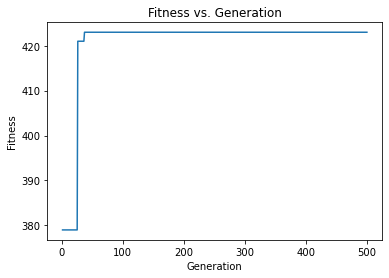

(-172.5569495937441 -33.258639922713556 -27.000103093420904 64.9095942901044 -121.90763303204503 -30.790092604671827 -14.416590199506516 -36.980871860421416 -132.0395865342 -68.6935950084515 104.9604723563798 123.35227703249343 58.563367098138194 -126.06061269363336 43.14692306328902 -68.75566708954742 -68.71609613571039 213.96084672307546 48.95086633749158 47.39309776016757 -168.8012504073943 38.21129720807244 332.5865099601887 -81.67918372370075 22.51533191517565 -58.43958610356149 180.04441725383538 -9.04005979618178 34.808184155728824 -123.90342059158903 391.2702054807162,
 [379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  379,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  4

In [35]:
geneticAlgorithm(55,5,0.12,500,'your_own_crossover','numcorrect')

Generation 0, Best Fitness: 332
Generation 100, Best Fitness: 421
Generation 200, Best Fitness: 421
Generation 300, Best Fitness: 421
Generation 400, Best Fitness: 421
Final Population Size: 55
Training Accuracy: 0.9252747252747253
Testing Accuracy: 0.8859649122807017
Number of Correctly Predicted Samples on Training Data: 421
Number of Correctly Predicted Samples on Testing Data: 101


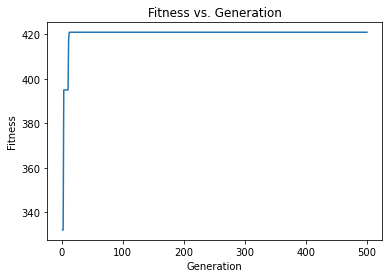

(-87.50878555730449 -10.882253679484634 205.12340510123903 30.03449068007515 -44.39118859891519 49.04322043778414 -81.5482712982444 76.00507887886538 42.244460075619756 39.58246256427758 158.30862679442106 -38.11780690728121 26.759630845769323 -65.6465859759342 46.2908803183266 92.29221810229474 97.20218903603464 -85.46678719197031 -55.26007963933879 -122.31449119879849 59.1962871691089 -25.372821282174826 238.91378869253847 -70.42680179357694 -19.32171332713675 64.889288910076 -87.15917541907973 -24.997958655883593 -143.09315008016637 91.41714662180144 -54.44363562574787,
 [332,
  332,
  395,
  395,
  395,
  395,
  395,
  395,
  395,
  395,
  418,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,
  421,


In [36]:
geneticAlgorithm(55,5,0.12,500,'your_own_crossover','numcorrect')

#### Own/Perceptron_fitness

Generation 0, Best Fitness: 3.936266934464695e-06
Generation 100, Best Fitness: 3.6902986252798796e-05
Generation 200, Best Fitness: 3.699245572886327e-05
Generation 300, Best Fitness: 4.323048182171055e-05
Generation 400, Best Fitness: 4.323048182171055e-05
Final Population Size: 55
Training Accuracy: 0.9384615384615385
Testing Accuracy: 0.9298245614035088
Number of Correctly Predicted Samples on Training Data: 427
Number of Correctly Predicted Samples on Testing Data: 106


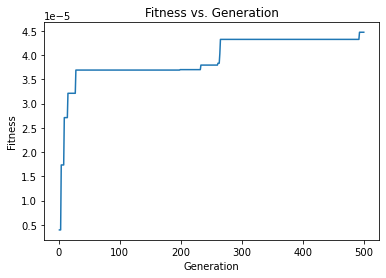

(-126.8546630806025 128.4897642966785 170.91861042549 -0.401359984161374 -383.4695266164665 -277.8900693099723 -401.9884540395325 -571.3849325002706 -206.78687228782871 -583.7222517674691 419.32045113422396 -703.1448839761819 -483.0268994923176 5.930084890278906 47.672685930176186 134.33488447631947 498.6303243939588 315.07680971297924 190.83425087068488 317.371652964198 235.0604081628848 -136.36674870711582 6.1502627277033355 -19.739887197202364 543.0476811789537 159.8477453245029 -770.679622194356 766.0399328190645 -72.7334287035801 939.1545289488412 652.8519889540188,
 [3.936266934464695e-06,
  3.936266934464695e-06,
  3.936266934464695e-06,
  1.7333567959853795e-05,
  1.7333567959853795e-05,
  1.7333567959853795e-05,
  1.7333567959853795e-05,
  1.7333567959853795e-05,
  2.7097080811475582e-05,
  2.7097080811475582e-05,
  2.7097080811475582e-05,
  2.7097080811475582e-05,
  2.7097080811475582e-05,
  2.7097080811475582e-05,
  3.2115344022243025e-05,
  3.2115344022243025e-05,
  3.21153

In [37]:
geneticAlgorithm(55,5,0.12,500,'your_own_crossover','perceptron_fitness')

Generation 0, Best Fitness: 5.672379665086458e-06
Generation 100, Best Fitness: 1.1018024103711565e-05
Generation 200, Best Fitness: 1.3386935786962107e-05
Generation 300, Best Fitness: 1.3386935786962107e-05
Generation 400, Best Fitness: 1.3809060465388509e-05
Final Population Size: 55
Training Accuracy: 0.945054945054945
Testing Accuracy: 0.8947368421052632
Number of Correctly Predicted Samples on Training Data: 430
Number of Correctly Predicted Samples on Testing Data: 102


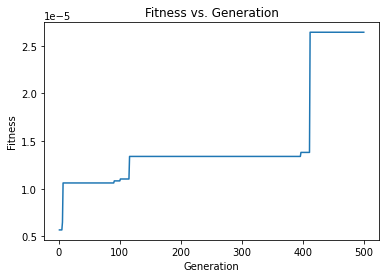

(136.97006522751946 -21.981457683056533 151.22018705178124 26.625659388205825 10.917159412501135 -127.3548003453107 57.532058731841744 208.41379636885083 -375.320364396804 187.71904230456616 -103.18234671903082 138.25610846193686 294.69457965539164 -103.94182754999937 -666.1377270998807 416.63399085408577 -778.2532785683352 140.42719668008922 153.6611338660962 -426.6314585799207 752.7164458176188 -72.03192730224418 -78.82102831242855 -40.80600007562377 368.4771754869938 -514.0710023969444 389.4234218904654 -660.7363939369559 -23.53885211043115 -206.54448780240432 1371.7115484768672,
 [5.672379665086458e-06,
  5.672379665086458e-06,
  5.672379665086458e-06,
  5.672379665086458e-06,
  5.672379665086458e-06,
  6.482743038178716e-06,
  1.0602026698346353e-05,
  1.0602026698346353e-05,
  1.0602026698346353e-05,
  1.0602026698346353e-05,
  1.0602026698346353e-05,
  1.0602026698346353e-05,
  1.0602026698346353e-05,
  1.0602026698346353e-05,
  1.0602026698346353e-05,
  1.0602026698346353e-05,


In [38]:
geneticAlgorithm(55,5,0.12,500,'your_own_crossover','perceptron_fitness')

Generation 0, Best Fitness: 2.562592958066017e-06
Generation 100, Best Fitness: 2.4550896348836267e-05
Generation 200, Best Fitness: 2.6767607423328107e-05
Generation 300, Best Fitness: 3.231949222992351e-05
Generation 400, Best Fitness: 3.448790762401512e-05
Final Population Size: 55
Training Accuracy: 0.9252747252747253
Testing Accuracy: 0.9035087719298246
Number of Correctly Predicted Samples on Training Data: 421
Number of Correctly Predicted Samples on Testing Data: 103


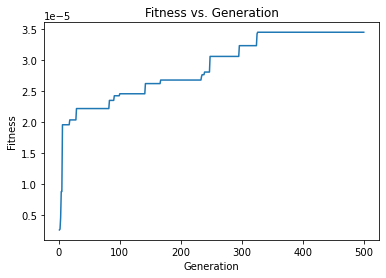

(-271.7793719864609 9.274600760432946 84.66628074050558 24.41845911526437 347.1938090008768 -102.67608341094447 391.37128437574717 -198.121418340737 -422.69597025057817 96.7710850183093 54.0730001871852 207.7843978032776 104.29584100307943 -66.3462158861445 321.1453206432815 -900.6948742470069 249.7658446371783 -333.46686455311675 181.87339065575856 73.48942714412179 540.366702410145 -77.37374262091947 20.710239333048833 -33.82297153472889 -41.17445328868854 -57.474256695153414 -48.52173134992266 105.79857071315129 103.7611919238168 496.2356558221021 200.319481777485,
 [2.562592958066017e-06,
  2.6961156338462153e-06,
  4.535279235548192e-06,
  8.751087251876927e-06,
  8.751087251876927e-06,
  1.9545679219293555e-05,
  1.9545679219293555e-05,
  1.9545679219293555e-05,
  1.9545679219293555e-05,
  1.9545679219293555e-05,
  1.9545679219293555e-05,
  1.9545679219293555e-05,
  1.9545679219293555e-05,
  1.9545679219293555e-05,
  1.9545679219293555e-05,
  1.9545679219293555e-05,
  1.954567921

In [39]:
geneticAlgorithm(55,5,0.12,500,'your_own_crossover','perceptron_fitness')

Generation 0, Best Fitness: 2.131622797923657e-06
Generation 100, Best Fitness: 2.839192596555573e-05
Generation 200, Best Fitness: 3.0278262891866117e-05
Generation 300, Best Fitness: 3.179261378886362e-05
Generation 400, Best Fitness: 3.320957059694564e-05
Final Population Size: 55
Training Accuracy: 0.9274725274725275
Testing Accuracy: 0.9298245614035088
Number of Correctly Predicted Samples on Training Data: 422
Number of Correctly Predicted Samples on Testing Data: 106


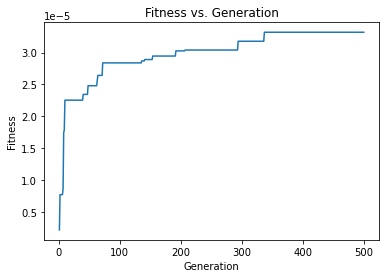

(153.94778219943282 87.3617243881928 32.79107104928279 26.057701919845258 -116.89729683777728 -7.482479078629481 -365.45056260663375 519.4978991531435 519.3423545141558 -192.65397423392136 -387.6643131100774 227.61599532440056 -946.2530963138024 17.887437631215356 100.00451628565648 -174.9461157180511 -560.0794911882248 -136.39324904711643 96.46323182391924 -304.83326156487186 198.84830754484227 -162.6170399596663 81.73609718084622 -37.33264712175994 -473.9240238612192 207.4870022717984 -883.7638624076743 134.65760222923666 -71.23999135431576 -73.08974706256365 854.0490097980187,
 [2.131622797923657e-06,
  7.683243954539111e-06,
  7.683243954539111e-06,
  7.683243954539111e-06,
  7.683243954539111e-06,
  7.683243954539111e-06,
  8.612329166257455e-06,
  1.7467927692225143e-05,
  1.782455372875721e-05,
  2.253131850417576e-05,
  2.253131850417576e-05,
  2.253131850417576e-05,
  2.253131850417576e-05,
  2.253131850417576e-05,
  2.253131850417576e-05,
  2.253131850417576e-05,
  2.25313185

In [40]:
geneticAlgorithm(55,5,0.12,500,'your_own_crossover','perceptron_fitness')

Generation 0, Best Fitness: 6.638293551942986e-06
Generation 100, Best Fitness: 8.0089267242557e-06
Generation 200, Best Fitness: 8.809968381114195e-06
Generation 300, Best Fitness: 9.164581427251808e-06
Generation 400, Best Fitness: 9.494697347941691e-06
Final Population Size: 55
Training Accuracy: 0.8945054945054945
Testing Accuracy: 0.8771929824561403
Number of Correctly Predicted Samples on Training Data: 407
Number of Correctly Predicted Samples on Testing Data: 100


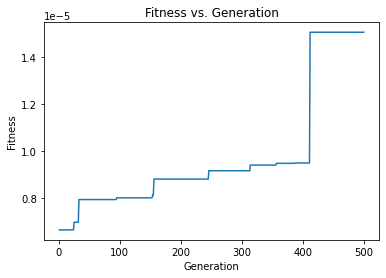

(-181.81792041132974 -213.02289125979263 -127.55615854072038 32.5438021544839 118.12046884144837 391.1110744702728 -455.40908566237 333.8698295428074 113.04408054206577 -68.15551377427558 -279.9031786410189 -523.3163436779948 390.652522303764 -25.126292406455462 553.3637346694679 -372.16390571651107 329.43385443774184 -130.46570515366793 -194.81134341107975 158.41467961207576 -241.96450156132397 151.19954137995876 325.30677809799346 -48.51680487816013 611.4654783524195 100.87007456607287 -231.53021837068798 341.36969938516137 283.17151859389185 -190.78814823547947 2360.910714635374,
 [6.638293551942986e-06,
  6.638293551942986e-06,
  6.638293551942986e-06,
  6.638293551942986e-06,
  6.638293551942986e-06,
  6.638293551942986e-06,
  6.638293551942986e-06,
  6.638293551942986e-06,
  6.638293551942986e-06,
  6.638293551942986e-06,
  6.638293551942986e-06,
  6.638293551942986e-06,
  6.638293551942986e-06,
  6.638293551942986e-06,
  6.638293551942986e-06,
  6.638293551942986e-06,
  6.638293

In [41]:
geneticAlgorithm(55,5,0.12,500,'your_own_crossover','perceptron_fitness')

#### Own2/Numcorrect

Generation 0, Best Fitness: 374
Generation 100, Best Fitness: 424
Generation 200, Best Fitness: 424
Generation 300, Best Fitness: 424
Generation 400, Best Fitness: 424
Final Population Size: 55
Training Accuracy: 0.9318681318681319
Testing Accuracy: 0.8859649122807017
Number of Correctly Predicted Samples on Training Data: 424
Number of Correctly Predicted Samples on Testing Data: 101


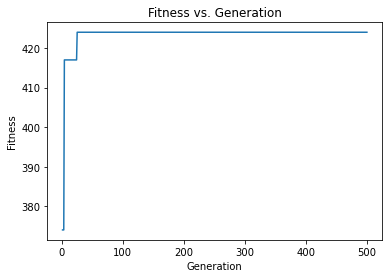

(159.7726547373081 -40.70731687136623 280.7439137446634 26.656177002256783 21.723830725314343 -25.45706298179249 -342.9416017772652 -66.88686473112624 110.33727487985281 126.4441291386903 166.90298331470086 211.4937807426856 -104.8792252937317 -25.988872579734533 -14.894838067706502 43.12578364281999 -11.085742371315959 -209.9154001851774 -189.17401676360646 -3.981874783120098 -155.80189817999292 -38.08368868905778 216.42407484394224 -76.06862248181754 75.30060740268162 72.52753117017042 -121.17155691079971 0.5444716365533537 -97.99474230862121 40.004226272126076 -299.32733194317194,
 [374,
  374,
  374,
  417,
  417,
  417,
  417,
  417,
  417,
  417,
  417,
  417,
  417,
  417,
  417,
  417,
  417,
  417,
  417,
  417,
  417,
  417,
  417,
  417,
  424,
  424,
  424,
  424,
  424,
  424,
  424,
  424,
  424,
  424,
  424,
  424,
  424,
  424,
  424,
  424,
  424,
  424,
  424,
  424,
  424,
  424,
  424,
  424,
  424,
  424,
  424,
  424,
  424,
  424,
  424,
  424,
  424,
  424,
  4

In [42]:
geneticAlgorithm(55,5,0.12,500,'your_own_crossover2','numcorrect')

Generation 0, Best Fitness: 393
Generation 100, Best Fitness: 423
Generation 200, Best Fitness: 423
Generation 300, Best Fitness: 423
Generation 400, Best Fitness: 423
Final Population Size: 55
Training Accuracy: 0.9296703296703297
Testing Accuracy: 0.8859649122807017
Number of Correctly Predicted Samples on Training Data: 423
Number of Correctly Predicted Samples on Testing Data: 101


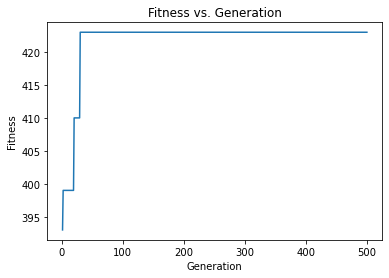

(132.71150803440685 73.39372091859465 147.57299945871156 44.66630162162326 -4.822672623372142 -97.21147315328955 116.3161946525865 -32.02043420917853 296.2524976645594 -155.34043795505198 -152.5006628849855 -125.1262844664573 -162.47899629957462 -15.267853805729679 -102.0444723554333 -85.91549006066965 103.62980300176278 -0.9160718631657119 -125.07093210674478 -182.93998234184548 62.45969300602542 -98.0140007195133 0.6587010253691687 -51.32955656104378 261.04097661661893 47.46149004446552 38.023826422403395 -63.11061077007374 53.579942427457354 -70.66646986215909 -149.71378136017364,
 [393,
  399,
  399,
  399,
  399,
  399,
  399,
  399,
  399,
  399,
  399,
  399,
  399,
  399,
  399,
  399,
  399,
  399,
  399,
  410,
  410,
  410,
  410,
  410,
  410,
  410,
  410,
  410,
  410,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  423,
  4

In [43]:
geneticAlgorithm(55,5,0.12,500,'your_own_crossover2','numcorrect')

Generation 0, Best Fitness: 402
Generation 100, Best Fitness: 404
Generation 200, Best Fitness: 404
Generation 300, Best Fitness: 404
Generation 400, Best Fitness: 404
Final Population Size: 55
Training Accuracy: 0.8879120879120879
Testing Accuracy: 0.8947368421052632
Number of Correctly Predicted Samples on Training Data: 404
Number of Correctly Predicted Samples on Testing Data: 102


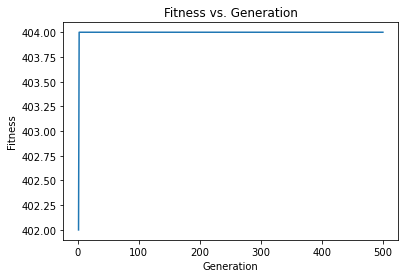

(59.009191104520255 -43.64250187133971 85.44781500246307 61.51530737967673 61.67369859635474 -57.23240943201351 58.51662210983184 -3.4496165557449103 -60.689860239416646 24.40235800031381 16.380333326024044 1.883438431669795 91.29179667307443 -33.788545158117 61.6127320937087 -48.81671610701481 60.5638701363801 -72.31517881175908 -25.563321800766687 91.77052932873585 31.096836649482995 31.8342113194839 36.635330588382686 -64.93268498853944 -4.986500964944284 9.65928129397362 -93.96139656417328 23.022312274910206 50.18016814502718 -60.99770086738432 -109.47713862495895,
 [402,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  404,
  40

In [44]:
geneticAlgorithm(55,5,0.12,500,'your_own_crossover2','numcorrect')

Generation 0, Best Fitness: 351
Generation 100, Best Fitness: 411
Generation 200, Best Fitness: 411
Generation 300, Best Fitness: 411
Generation 400, Best Fitness: 411
Final Population Size: 55
Training Accuracy: 0.9032967032967033
Testing Accuracy: 0.8596491228070176
Number of Correctly Predicted Samples on Training Data: 411
Number of Correctly Predicted Samples on Testing Data: 98


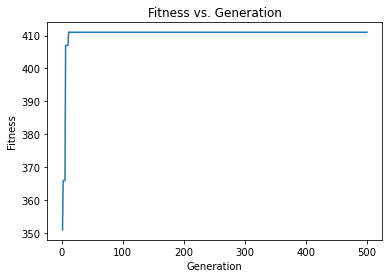

(104.79931397467368 50.87354658993249 -17.915781238036814 3.0214324000792985 -7.770383536704571 -0.15374295740366506 -142.3160161201128 -1.3563453267281318 -133.96068479371493 -49.45838277856123 49.434768989373396 -32.396333661159375 -60.20878320032732 -9.92541775084112 -49.244078333073645 -4.239411778553368 -46.55344346528088 -51.016476623759196 -56.381278829507195 -42.09207269351097 -78.19942169117363 35.39003952646277 81.96260771951908 -12.175580443128268 25.403057017733836 -61.88499099354187 -145.38961704418494 145.08417218705185 69.1938715087102 118.55661825947097 -106.5414738173542,
 [351,
  366,
  366,
  366,
  366,
  407,
  407,
  407,
  407,
  407,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411,
  411

In [45]:
geneticAlgorithm(55,5,0.12,500,'your_own_crossover2','numcorrect')

Generation 0, Best Fitness: 323
Generation 100, Best Fitness: 413
Generation 200, Best Fitness: 413
Generation 300, Best Fitness: 413
Generation 400, Best Fitness: 413
Final Population Size: 55
Training Accuracy: 0.9164835164835164
Testing Accuracy: 0.8333333333333334
Number of Correctly Predicted Samples on Training Data: 417
Number of Correctly Predicted Samples on Testing Data: 95


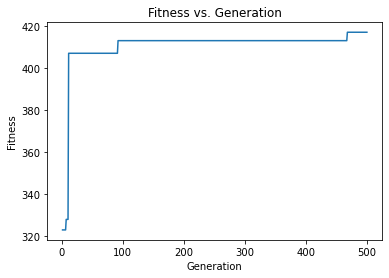

(-176.59292732924206 1077.2718228417982 110.70651998833372 26.66350747278598 -303.07728011880386 -93.28103391004015 -846.1463955583332 -383.1472684711156 146.94479137877366 -382.41059182505916 -199.7962507122623 314.12754057940964 -177.7254604719175 -169.44331604604727 337.5823567370994 -115.6920893402474 311.45793038963654 630.9227663459102 582.7783526341782 275.00851632980715 -274.2534056142554 -379.3310211188062 89.61089083348624 -42.09693437806813 -369.22440452200124 -576.8178802568285 -341.52524578617385 -55.53466486214684 -790.5512938630818 75.77718957388166 -271.0457496323237,
 [323,
  323,
  323,
  323,
  323,
  323,
  328,
  328,
  328,
  328,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  407,
  4

In [46]:
geneticAlgorithm(55,5,0.12,500,'your_own_crossover2','numcorrect')

#### Own2/Perceptron_fitness

Generation 0, Best Fitness: 2.712632241659502e-06
Generation 100, Best Fitness: 5.418424268295427e-06
Generation 200, Best Fitness: 1.184549958718109e-05
Generation 300, Best Fitness: 1.184549958718109e-05
Generation 400, Best Fitness: 1.184549958718109e-05
Final Population Size: 55
Training Accuracy: 0.9098901098901099
Testing Accuracy: 0.8508771929824561
Number of Correctly Predicted Samples on Training Data: 414
Number of Correctly Predicted Samples on Testing Data: 97


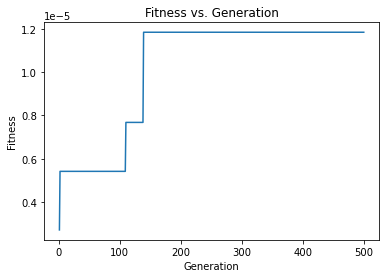

(283.94494328376555 55.89570888674227 87.83084322151956 12.262846927815886 170.9746863881398 269.0338984354419 -291.01133445798223 -43.77155943704068 -189.17787323557107 120.63101346946269 -401.692410955392 123.03065897848987 -174.17018298458942 -160.06638126608942 100.63326517326178 85.58962733370834 -363.56714572486834 161.7155666777446 -143.04754392718525 108.97215537852993 -1.8204756320142366 52.88228302867359 124.620653002394 -38.43383255447949 -109.43598033290205 -206.97002624029471 145.40751846806586 71.98785210834333 -456.37281671977735 177.2387649378761 -91.42694251525587,
 [2.712632241659502e-06,
  5.418424268295427e-06,
  5.418424268295427e-06,
  5.418424268295427e-06,
  5.418424268295427e-06,
  5.418424268295427e-06,
  5.418424268295427e-06,
  5.418424268295427e-06,
  5.418424268295427e-06,
  5.418424268295427e-06,
  5.418424268295427e-06,
  5.418424268295427e-06,
  5.418424268295427e-06,
  5.418424268295427e-06,
  5.418424268295427e-06,
  5.418424268295427e-06,
  5.4184242

In [47]:
geneticAlgorithm(55,5,0.12,500,'your_own_crossover2','perceptron_fitness')

Generation 0, Best Fitness: 1.5667481975835026e-06
Generation 100, Best Fitness: 1.3978911957794698e-05
Generation 200, Best Fitness: 3.080413722471261e-05
Generation 300, Best Fitness: 3.1621100952908584e-05
Generation 400, Best Fitness: 3.4227715672951155e-05
Final Population Size: 55
Training Accuracy: 0.9318681318681319
Testing Accuracy: 0.9035087719298246
Number of Correctly Predicted Samples on Training Data: 424
Number of Correctly Predicted Samples on Testing Data: 103


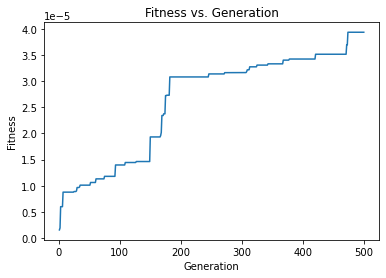

(-74.55165556363852 -92.31405121618641 91.44449956226279 18.06192391682454 -167.33366884996488 259.76357490141146 -732.437386104451 293.8783993620929 -148.89887603790598 -11.496908144421269 56.96073186182092 -196.3119795455409 667.575522390853 -90.1534322581237 -331.68119912752957 -73.11655706644368 -289.6399108820985 -261.0640408808957 -231.4488647507108 -572.9670494431007 429.6397357700659 -14.311804986288493 16.22341156497818 -28.36720562797757 -295.3300719690495 -41.695065125718145 -498.4650785785781 48.253989781852496 54.05207307283109 -341.9366426391649 -485.50365360108594,
 [1.5667481975835026e-06,
  1.941990207174024e-06,
  6.008727043100509e-06,
  6.008727043100509e-06,
  6.008727043100509e-06,
  6.008727043100509e-06,
  8.78623505293465e-06,
  8.78623505293465e-06,
  8.78623505293465e-06,
  8.78623505293465e-06,
  8.78623505293465e-06,
  8.78623505293465e-06,
  8.78623505293465e-06,
  8.78623505293465e-06,
  8.78623505293465e-06,
  8.78623505293465e-06,
  8.78623505293465e-06

In [48]:
geneticAlgorithm(55,5,0.12,500,'your_own_crossover2','perceptron_fitness')

Generation 0, Best Fitness: 9.214515883918309e-06
Generation 100, Best Fitness: 1.864651672940457e-05
Generation 200, Best Fitness: 1.864651672940457e-05
Generation 300, Best Fitness: 1.864651672940457e-05
Generation 400, Best Fitness: 1.864651672940457e-05
Final Population Size: 55
Training Accuracy: 0.9252747252747253
Testing Accuracy: 0.9210526315789473
Number of Correctly Predicted Samples on Training Data: 421
Number of Correctly Predicted Samples on Testing Data: 105


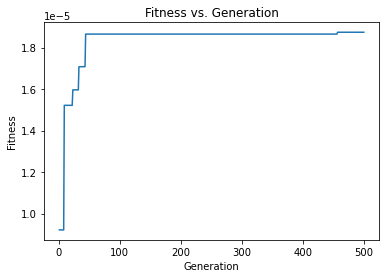

(325.37423901537557 -95.63752060058559 166.39642517047355 29.076833285851947 -16.819403860840623 391.2447546356882 -252.6581587783185 -319.852735966787 -1007.2657072336904 -376.5022183751054 460.2963716538854 66.51678765735866 524.8151358197438 -129.64985432788103 -942.3090064838069 302.1252612325014 167.7899346193948 -382.8359939738388 287.1620979354447 -690.3430352925697 420.6325232726501 -156.95259332968905 91.9110018526293 -57.93981347040144 284.31593801388516 -338.37667664310317 426.6401065136546 35.26569058476778 -459.5000561867279 335.5884081057294 196.45334258963697,
 [9.214515883918309e-06,
  9.214515883918309e-06,
  9.214515883918309e-06,
  9.214515883918309e-06,
  9.214515883918309e-06,
  9.214515883918309e-06,
  9.214515883918309e-06,
  9.214515883918309e-06,
  1.521555330124538e-05,
  1.521555330124538e-05,
  1.521555330124538e-05,
  1.521555330124538e-05,
  1.521555330124538e-05,
  1.521555330124538e-05,
  1.521555330124538e-05,
  1.521555330124538e-05,
  1.52155533012453

In [49]:
geneticAlgorithm(55,5,0.12,500,'your_own_crossover2','perceptron_fitness')

Generation 0, Best Fitness: 2.175199391338362e-05
Generation 100, Best Fitness: 3.3266778196992445e-05
Generation 200, Best Fitness: 3.3266778196992445e-05
Generation 300, Best Fitness: 3.670435480649534e-05
Generation 400, Best Fitness: 3.670435480649534e-05
Final Population Size: 55
Training Accuracy: 0.9230769230769231
Testing Accuracy: 0.9122807017543859
Number of Correctly Predicted Samples on Training Data: 420
Number of Correctly Predicted Samples on Testing Data: 104


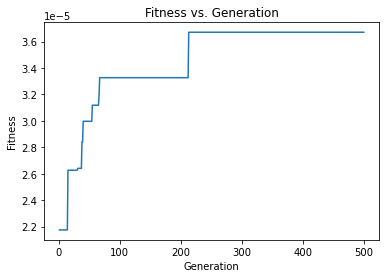

(298.7277366941888 94.33341531178549 -10.317323848757908 19.756014207400185 -538.3817232823436 -44.71322652638962 -404.8946390425725 116.8007803287597 -235.9603359722584 -213.65961415493334 233.38164078275537 228.46348898071832 229.84944599606445 -73.00697966120481 -34.68828089396558 -5.045913874087262 -72.13731090307147 -120.60203780293887 227.49494842128667 178.68054629708962 -32.9268984999032 -161.53811578756066 94.58422075344251 -27.034080468392773 297.44001615810794 452.1995873935136 -293.0541968119445 163.930216830562 314.37750167807644 44.221100174988536 206.02426238870692,
 [2.175199391338362e-05,
  2.175199391338362e-05,
  2.175199391338362e-05,
  2.175199391338362e-05,
  2.175199391338362e-05,
  2.175199391338362e-05,
  2.175199391338362e-05,
  2.175199391338362e-05,
  2.175199391338362e-05,
  2.175199391338362e-05,
  2.175199391338362e-05,
  2.175199391338362e-05,
  2.175199391338362e-05,
  2.175199391338362e-05,
  2.6266347731526095e-05,
  2.6266347731526095e-05,
  2.626634

In [50]:
geneticAlgorithm(55,5,0.12,500,'your_own_crossover2','perceptron_fitness')

Generation 0, Best Fitness: 1.1733108816090182e-06
Generation 100, Best Fitness: 2.8926169452337325e-05
Generation 200, Best Fitness: 2.8926169452337325e-05
Generation 300, Best Fitness: 2.8926169452337325e-05
Generation 400, Best Fitness: 2.8926169452337325e-05
Final Population Size: 55
Training Accuracy: 0.9010989010989011
Testing Accuracy: 0.8859649122807017
Number of Correctly Predicted Samples on Training Data: 410
Number of Correctly Predicted Samples on Testing Data: 101


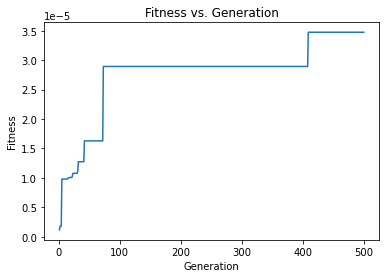

(537.3394807802986 59.87845197741089 50.86691427029531 -8.491209535986435 453.4396637140966 -539.8174277990132 420.7384179036749 -339.8501902890013 259.53984817434264 -315.7044628480627 558.0813221699948 -28.37405595394405 302.3941957735765 -119.30426887959044 -866.0502057483219 -325.59901990519427 95.0347038382082 106.99735474813193 -802.1626275646219 -816.6579515146013 -360.12300690615723 -109.11098703310111 0.38658700778584887 2.835389130283474 745.0801076229646 -554.6981061426158 -327.7803764588915 299.817733326685 -186.51468163141078 -345.40845866029554 1550.076122459244,
 [1.1733108816090182e-06,
  1.8014738110281658e-06,
  1.8014738110281658e-06,
  1.8014738110281658e-06,
  9.802408053719991e-06,
  9.802408053719991e-06,
  9.802408053719991e-06,
  9.802408053719991e-06,
  9.802408053719991e-06,
  9.802408053719991e-06,
  9.802408053719991e-06,
  9.802408053719991e-06,
  9.802408053719991e-06,
  9.802408053719991e-06,
  9.975870153274727e-06,
  9.975870153274727e-06,
  1.00776978

In [51]:
geneticAlgorithm(55,5,0.12,500,'your_own_crossover2','perceptron_fitness')